In [1]:
#####################################################################
# This notebook is authored by: Ayan Paul & Lina Alasfar            #
# Date: May 2022                                                    #
# If you use this code or the results from this work please cite:   # 
# Machine learning the trilinear and light-quark Yukawa couplings   #
# from Higgs pair kinematic shapes                                  #
# Lina Alasfar, Ramona Gröber, Christophe Grojean, Ayan Paul        #
# and Zuoni Qian                                                    #
# arXiv:2207.04157 (https://arxiv.org/abs/2207.04157)               #  
#####################################################################

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import ensemble
import sklearn.model_selection as ms
from sklearn import metrics
import shap
import matplotlib.pyplot as plt
import os
import math as m
import collections
import pickle
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from colour import Color
from matplotlib import rc
import sys
from joblib import Parallel, delayed
import time

plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams['font.family'] = 'monospace'


# To supress warnings from shap
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

N_THREADS = 25 ## Change for reducing load on CPU
os.environ['OMP_NUM_THREADS'] = str(N_THREADS)
seed = 420

colors = ['#3f7f93','#da3b46']
cmp_2 = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors], N=len(colors))

colors = ['#98b83b','#3f7f93','#da3b46']
cmp_3 = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors], N=len(colors))

colors = ['#3f7f93','#da3b46','#F6AE2D', '#98b83b']
cmp_4 = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors], N=len(colors))

colors = ['#3f7f93','#da3b46','#F6AE2D', '#98b83b', '#825FC3']
cmp_5 = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors], N=len(colors))

colors = ['#60a0af', '#af6079', '#a8b96f', '#fcb880', '#FDD7D0', '#a5d6e0']
cmp_6 = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors], N=len(colors))

colors = ['#60a0af', '#af6079', '#a8b96f', '#fcb880', '#FDD7D0', '#a5d6e0', '#825FC3']
cmp_7 = LinearSegmentedColormap.from_list('my_list', [Color(c1).rgb for c1 in colors], N=len(colors))

# how far in eta the endcap goes
ENDCAP = 4

In [2]:
def fileparser(path, dlist, sclass, sample, L=1, cut=False):
    """ The fileparser to read the events from a csv
        argument:
            path: the path to the file
            dlist: the list of variables to be excluded
            sample: the number of events that will be the train sample.
            L: Luminosity scaling
        returns:
            df_train: the training dataframe
            df_test: the testing dataframe
            weight: the weight (related to crosssection)
    """
    df = pd.read_csv(path)
    
    n = len(df)
    df['class'] = sclass
    weight = int(round(np.abs(df['weight'].sum()) * 3. * 1e7 * L)) ## The abs(mean()) is taken to make the weight of ybyt +ve
    if cut: 
        N_cut = df.drop(df[((np.abs(df['etaa1'])>ENDCAP) | (np.abs(df['etaa2'])>ENDCAP) | (np.abs(df['etab1'])>ENDCAP) | (np.abs(df['etab2'])>ENDCAP))].index).shape[0]/df.shape[0]
        df = df.drop(df[((np.abs(df['etaa1'])>ENDCAP) | (np.abs(df['etaa2'])>ENDCAP) | (np.abs(df['etab1'])>ENDCAP) | (np.abs(df['etab2'])>ENDCAP))].index).shape[0]
        weight /= N_cut
        
    df_train = df.sample(n=sample, random_state=seed)
    df_test = df.drop(df_train.index)
        
    df_train.drop(columns=dlist, inplace=True)
    df_test.drop(columns=dlist, inplace=True)
    return df_train, df_test, weight


def runBDT(df, filename='', rf=False, depth=10, sample=1, seed=seed):
    """ The BDT/RF runner
        argument:
            df: the dataframe with all the events
            filename: the name of the pickle file to store the model in
            rf: a bolean to toggle between BDT and Random Forest classifiers
            sample: The fraction of variables to sample
            seed: the seed for the random number generator
        returns:
            classifier: the classifier
            x_test: the features for the test set
            y_test: the labels for the test set
            shap_values: the SHAP values
            X_shap: the feature set with which the shap values have been computed
    """
    mshap = True if depth <= 10 else False
    df = df.sample(frac=sample)
    nchannels = len(df['class'].unique())
    X = df.drop(columns=['class', 'weight'])
    y = df['class'].values

    # Split for training and testing
    x_train, x_test, y_train, y_test = ms.train_test_split(X.values, y, test_size=0.2, random_state=seed)
    eval_set = [(x_train, y_train), (x_test, y_test)]
    
    # Fit the decision tree
    if rf: 
        classifier = ensemble.RandomForestClassifier(max_depth=depth, n_estimators=1000, criterion='gini', n_jobs=int(N_THREADS/2), random_state=seed)
        classifier = classifier.fit(x_train, y_train)
    else: 
        classifier = xgb.XGBClassifier(max_depth=depth, learning_rate=0.1, objective='multi:softprob', num_class=nchannels,
                                       n_jobs=N_THREADS, subsample=1, colsample_bytree=1, n_estimators=5000, random_state=seed)
        classifier = classifier.fit(x_train, y_train, early_stopping_rounds=30, eval_set=eval_set,
                                eval_metric=["merror", "mlogloss"], verbose=False)
    
    # Predictions
    y_pred = classifier.predict(x_test)
    print('Accuracy Score: {:4.2f}% '.format(100*metrics.accuracy_score(y_test, y_pred)))
    if filename != '': pickle.dump(classifier, open(filename, 'wb'))
    
    # Calculate the SHAP scores
    if mshap:
        X_shap = pd.DataFrame(x_test, columns=df.drop(columns=['class', 'weight']).columns)
        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(X_shap)
    else:
        shap_values = []
        X_shap = pd.DataFrame()
        
    return classifier, x_test, y_test, shap_values, X_shap


def eval_training(classifier):
    """ Evaluate the training
        argument:
            classifier: the BDT classifier
    """
    results = classifier.evals_result()
    epochs = len(results['validation_0']['merror'])
    x_axis = range(0, epochs)

    # plot log loss
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(x_axis, results['validation_0']['mlogloss'], label='train')
    plt.plot(x_axis, results['validation_1']['mlogloss'], label='test')
    plt.legend()

    plt.ylabel('log loss')
    plt.title('Classifier log loss')
    plt.grid()

    # plot classification error
    plt.subplot(1, 2, 2)
    plt.plot(x_axis, results['validation_0']['merror'], label='train')
    plt.plot(x_axis, results['validation_1']['merror'], label='test')
    plt.legend()

    plt.ylabel('Classification Error')
    plt.title('Classification Error')
    plt.grid()
    plt.show()
    
    
def abs_shap(df_shap, df, shap_plot, names, class_names, cmp):
    ''' A function to plot the bar plot for the mean abs SHAP values
        arguments:
            df_shap: the dataframe of the SHAP values
            df: the dataframe for the feature values for which the SHAP values have been determined
            shap_plot: The name of the output file for the plot
            names: The names of the variables
            class_names: names of the classes
            cmp: the colour map
    '''
    rc('text', usetex=True)
    plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
    plt.figure(figsize=(5,5))
    shap.summary_plot(df_shap, df, color=cmp, class_names=class_names, class_inds='original', plot_size=(5,5), show=False, feature_names=names)
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), loc='lower right', fontsize=15)
    plt.xlabel(r'$\overline{|S_v|}$', fontsize=15)
    ax = plt.gca()
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    ax.spines["left"].set_visible(True)
    vals = ax.get_xticks()
    ax.tick_params(axis='both', which='major', labelsize=15)
    for tick in vals:
        ax.axvline(x=tick, linestyle='dashed', alpha=0.7, color='#808080', zorder=0, linewidth=0.5)
    plt.annotate('FCC-hh', xy=(0.5, 0.01), xycoords='axes fraction', horizontalalignment='center',
                verticalalignment='bottom', fontsize=20, fontweight='900', zorder=100, color='#474747')
    plt.tight_layout()
    plt.savefig(shap_plot, dpi=300)
    rc('text', usetex=False)
    
def get_mclass(i, df_array, weight_array, ps_exp_class, seed=seed):
    """ This function is used to create the confusion matrix
        arguments:
            i: integer corresponding to the class number
            df_array: the array of the dataframes of the different classes
            weight_array: the array of the weights for the different classes
            ps_exp_class: the collection of the pseudo experiment events
            seed: the seed for the random number generator
        returns:
            nevents: the number of events
    """
    nchannels = len(df_array)
    mclass = []
    for j in range(nchannels):
        mclass.append(collections.Counter(classifier.predict(df_array[j].iloc[:,:-2].values))[i]/len(df_array[j])*weight_array[j]/weight_array[i])
    nevents = np.round(ps_exp_class[i]/np.sum(mclass)*np.array(mclass)).astype(int)
    return nevents


def build_confusion(df, weight, clf, filename, keys):
    """ Export the confusion matrix to a json
        argument:
            df: array of dataframes with the signal and background
            weight: array of weights for the signal and background
            clf: the classifier
            filename: the name of the file to export to
            keys: the channel names for which the confusion matrix is created
        returns:
            df: dataframe with the confusion matrix
    """
    ps_exp_class = collections.Counter(clf.predict(
        pd.concat([df[i].iloc[:,:-2].sample(n=round(weight[i]), random_state=seed, replace=True) for i in range(len(df))])
        .values))

    confusion = np.column_stack([get_mclass(i, df, weight, ps_exp_class) for i in reversed(range(len(df)))])
    
    df = pd.DataFrame(confusion.T)
    df = df[df.columns[::-1]]
    df.columns = keys
    df.index = keys
    df = df.T
    df['total'] = df.sum(axis=1)
    df = df.T
    df['Z'] = 0
    for key in keys:
        df.loc[key,'Z'] = df.loc[key, key]/np.sqrt(df.loc[key].sum())
    df.T.to_json(filename)
    return df

In [3]:
dlist = ['ptb2', 'etaaa', 'dphibb', 'drba1', 'dphiba1', 'drbamin', 'nbjet', 'etab2']

# k-factors
k_box = 1.98
k_int = 2.15
k_tri = 2.28
k_bbh_yb2 = 1.5
k_bbh_ybyt = 1.9
k_bbh_yt2 = 2.5
k_bbh_zh = 1.3
k_tth = 1.2
k_bbxaa = 1.5
k_ku = 1.29
k_kd = 1.3

# 14 TeV
path = '../simulations/FCC-hh/'

# The bbxaa background
df_bbxaa, df_bbxaa_test, weight_bbxaa = fileparser(path+"bbxaa.tar.gz", dlist, sclass=0, sample=120000)
weight_bbxaa = weight_bbxaa*k_bbxaa

# The tth+bbh background
fact = 0.3
df_tth, df_tth_test, weight_tth = fileparser(path+"ttH.tar.gz", dlist, sclass=1, sample=int(188372*fact))
df_yb2, df_yb2_test, weight_yb2 = fileparser(path+"yb2.tar.gz", dlist, sclass=1, sample=int(20259*fact))
df_ybyt, df_ybyt_test, weight_ybyt = fileparser(path+"ybyt.tar.gz", dlist, sclass=1, sample=int(3910*fact))
df_yt2, df_yt2_test, weight_yt2 = fileparser(path+"yt2.tar.gz", dlist, sclass=1, sample=int(91992*fact))
df_zh, df_zh_test, weight_zh = fileparser(path+"zh.tar.gz", dlist, sclass=1, sample=int(7047*fact))

df_bbh_tth = pd.concat([df_tth, df_yb2, df_ybyt, df_yt2, df_zh])
df_bbh_tth_test = pd.concat([df_tth_test, df_yb2_test, df_ybyt_test, df_yt2_test, df_zh_test])
weight_bbh_tth = int(weight_tth*k_tth + weight_yb2*k_bbh_yb2 - weight_ybyt*k_bbh_ybyt + weight_yt2*k_bbh_yt2 + weight_zh*k_bbh_zh)

# The hhsm signal
df_hhsm_b, df_hhsm_b_test, weight_hhsm_b = fileparser(path+"HH-box.tar.gz", dlist, sclass=2, sample=20000)
df_hhsm_i, df_hhsm_i_test, weight_hhsm_i = fileparser(path+"HH-int.tar.gz", dlist, sclass=3, sample=20000)
df_hhsm_t, df_hhsm_t_test, weight_hhsm_t = fileparser(path+"HH-tri.tar.gz", dlist, sclass=4, sample=20000)
weight_hhsm_b = weight_hhsm_b*k_box
weight_hhsm_i = weight_hhsm_i*k_int
weight_hhsm_t = weight_hhsm_t*k_tri

fact = 0.06
df_hhsm = pd.concat([df_hhsm_b.sample(n=int(weight_hhsm_b*fact)), df_hhsm_i.sample(n=int(weight_hhsm_i*fact)), df_hhsm_t.sample(n=int(weight_hhsm_t*fact))])
df_hhsm['class'] = 2
df_hhsm_test = pd.concat([df_hhsm_b_test, df_hhsm_i_test, df_hhsm_t_test])
df_hhsm_test['class'] = 2
weight_hhsm = int(weight_hhsm_b - weight_hhsm_i + weight_hhsm_t)

# kappa_u and kappa_d
df_ku, df_ku_test, weight_ku = fileparser(path+"ku-480.tar.gz", dlist, sclass=5, sample=20000)
df_kd, df_kd_test, weight_kd = fileparser(path+"kd-225.tar.gz", dlist, sclass=5, sample=20000)
weight_ku = weight_ku*k_ku
weight_kd = weight_kd*k_kd


print("No. of kappa_d triangle events: train = {}, test = {}".format(df_kd.shape[0],df_kd_test.shape[0]))
print("No. of kappa_u triangle events: train = {}, test = {}".format(df_ku.shape[0],df_ku_test.shape[0]))
print("No. of hhsm events: train = {}, test = {}".format(df_hhsm.shape[0],df_hhsm_test.shape[0]))
print("No. of hhsm triangle events: train = {}, test = {}".format(df_hhsm_t.shape[0],df_hhsm_t_test.shape[0]))
print("No. of hhsm interference events: train = {}, test = {}".format(df_hhsm_i.shape[0],df_hhsm_i_test.shape[0]))
print("No. of hhsm box events: train = {}, test = {}".format(df_hhsm_b.shape[0],df_hhsm_b_test.shape[0]))
print("No. of bbh+tth events: train = {}, test = {}".format(df_bbh_tth.shape[0],df_bbh_tth_test.shape[0]))
print("No. of bbxaa events: train = {}, test = {}".format(df_bbxaa.shape[0],df_bbxaa_test.shape[0]))

names = [r'$n_{jet}$', r'$p_T^{b_1}$', r'$p_T^{\gamma_1}$', r'$p_T^{\gamma_2}$', r'$p_T^{\gamma\gamma}$', r'$\eta_{b_1}$', r'$\eta_{\gamma_1}$', r'$\eta_{\gamma_2}$',
         r'$m_{bb}$', r'$m_{\gamma\gamma}$', r'$m_{b_1h}$', r'$m_{bbh}$', r'$E^{\rm miss}_T$', r'$H_T$']

No. of kappa_d triangle events: train = 20000, test = 127973
No. of kappa_u triangle events: train = 20000, test = 45908
No. of hhsm events: train = 10904, test = 263935
No. of hhsm triangle events: train = 20000, test = 83648
No. of hhsm interference events: train = 20000, test = 87973
No. of hhsm box events: train = 20000, test = 92314
No. of bbh+tth events: train = 93472, test = 1089272
No. of bbxaa events: train = 120000, test = 106981


## Just kappa_u and kappa_d

In [4]:
df_ku['class'] = 1
df_ku_test['class'] = 1
df_kd['class'] = 0
df_kd_test['class'] = 0

channels = [df_ku, df_kd]
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

names_orig = names

Accuracy Score: 54.11% 


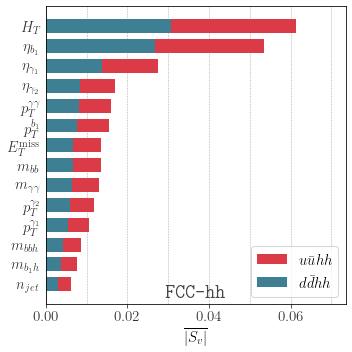

In [5]:
class_names = [r'$d \bar d hh$', r'$u \bar u hh$']
filename = '../results/models/FCC-hh-BDT/hh-BDT-2class-ku-kd.pickle.dat'
shap_plot = '../plots/FCC-hh-shap-ku-kd.pdf'

classifier, x_test, y_test, shap_values_2ud, X_shap_2ud = runBDT(df_train, filename, depth=10)
abs_shap(shap_values_2ud, X_shap_2ud, shap_plot, names=names, class_names=class_names, cmp=cmp_5)

In [6]:
ku_p = df_ku_test.sample(n=round(weight_ku), replace=True, random_state=seed).reset_index(drop=True)
kd_p = df_kd_test.sample(n=round(weight_kd), replace=True, random_state=seed).reset_index(drop=True)

print('Accuracy Score for ku: {:4.2f}% '.format(100*metrics.accuracy_score(ku_p['class'].values, classifier.predict(ku_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for kd: {:4.2f}% '.format(100*metrics.accuracy_score(kd_p['class'].values, classifier.predict(kd_p.drop(columns=['class', 'weight']).values))))

Accuracy Score for ku: 42.29% 
Accuracy Score for kd: 62.09% 


In [7]:
df_array = [df_kd_test, df_ku_test]
weight_array = [weight_kd, weight_ku]
keys = ['ku', 'kd']
filename = '../results/confusion/FCC-hh-BDT/hh-BDT-2class-ku-kd.confusion.json'

df = build_confusion(df_array, weight_array, classifier, filename, keys)
df

,ku,kd,Z
ku,17641,16839,95.003493
kd,24223,27408,120.620765
total,41864,44247,0.000000


## hh and kappa_u, kappa_d

In [8]:
df_ku['class'] = 2
df_ku_test['class'] = 2
df_kd['class'] = 1
df_kd_test['class'] = 1
df_hhsm['class'] = 0
df_hhsm_test['class'] = 0

channels = [df_ku, df_kd, df_hhsm]
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

names_orig = names

Accuracy Score: 45.58% 


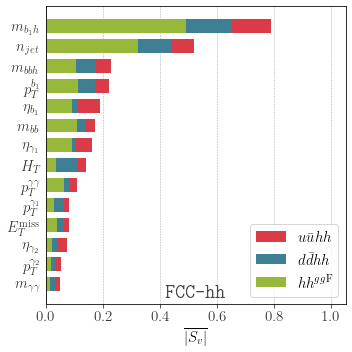

In [9]:
class_names = [r'$hh^{gg\rm F}$', r'$d \bar d hh$', r'$u \bar u hh$']
filename = '../results/models/FCC-hh-BDT/hh-BDT-2class-ku-kd-hhsm.pickle.dat'
shap_plot = '../plots/FCC-hh-shap-ku-kd-hhsm.pdf'

classifier, x_test, y_test, shap_values_3ud, X_shap_3ud = runBDT(df_train, filename, depth=10)
abs_shap(shap_values_3ud, X_shap_3ud, shap_plot, names=names, class_names=class_names, cmp=cmp_3)

In [10]:
ku_p = df_ku_test.sample(n=round(weight_ku), replace=True, random_state=seed).reset_index(drop=True)
kd_p = df_kd_test.sample(n=round(weight_kd), replace=True, random_state=seed).reset_index(drop=True)
hhsm_p = df_hhsm_test.sample(n=round(weight_hhsm), replace=True, random_state=seed).reset_index(drop=True)

print('Accuracy Score for ku: {:4.2f}% '.format(100*metrics.accuracy_score(ku_p['class'].values, classifier.predict(ku_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for kd: {:4.2f}% '.format(100*metrics.accuracy_score(kd_p['class'].values, classifier.predict(kd_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for hhsm: {:4.2f}% '.format(100*metrics.accuracy_score(hhsm_p['class'].values, classifier.predict(hhsm_p.drop(columns=['class', 'weight']).values))))

Accuracy Score for ku: 42.11% 
Accuracy Score for kd: 49.39% 
Accuracy Score for hhsm: 44.66% 


In [11]:
df_array = [df_kd_test, df_ku_test, df_hhsm_test]
weight_array = [weight_kd, weight_ku, weight_hhsm]
keys = ['ku', 'kd', 'hhsm']
filename = '../results/confusion/FCC-hh-BDT/hh-BDT-2class-ku-kd-hhsm.confusion.json'

df = build_confusion(df_array, weight_array, classifier, filename, keys)
df

,ku,kd,hhsm,Z
ku,10379,17677,16936,48.931425
kd,19282,19183,21751,78.173683
hhsm,23809,4999,5569,30.036079
total,53470,41859,44256,0.000000


_________________________________
## kappa_u

In [12]:
df_ku['class'] = 3
df_ku_test['class'] = 3
df_hhsm['class'] = 2
df_hhsm_test['class'] = 2

channels = [df_ku, df_hhsm, df_bbh_tth, df_bbxaa]
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

Accuracy Score: 86.51% 


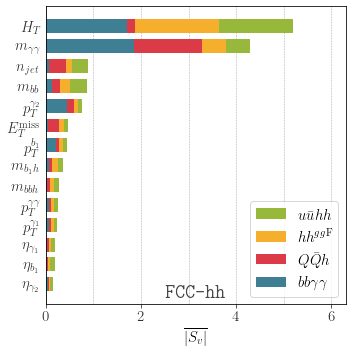

In [13]:
class_names = [r'$bb\gamma\gamma$', r'$Q\bar{Q}h$', r'$hh^{gg\rm F}$', r'$u \bar u hh$']
filename = '../results/models/FCC-hh-BDT/hh-BDT-4class-ku.pickle.dat'
shap_plot = '../plots/FCC-hh-shap-bbxaa-bbh-tth-hhsm-ku-only.pdf'

classifier, x_test, y_test, shap_values_4u, X_shap_4u = runBDT(df_train, filename, depth=10)
abs_shap(shap_values_4u, X_shap_4u, shap_plot, names=names, class_names=class_names, cmp=cmp_5)

In [14]:
ku_p = df_ku_test.sample(n=round(weight_ku), replace=True, random_state=seed).reset_index(drop=True)
hhsm_p = df_hhsm_test.sample(n=round(weight_hhsm), replace=True, random_state=seed).reset_index(drop=True)
bbh_tth_p = df_bbh_tth_test.sample(n=round(weight_bbh_tth), replace=True, random_state=seed).reset_index(drop=True)
bbxaa_p = df_bbxaa_test.sample(n=round(weight_bbxaa), replace=True, random_state=seed).reset_index(drop=True)

print('Accuracy Score for ku: {:4.2f}% '.format(100*metrics.accuracy_score(ku_p['class'].values, classifier.predict(ku_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for hhsm: {:4.2f}% '.format(100*metrics.accuracy_score(hhsm_p['class'].values, classifier.predict(hhsm_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for bbh+tth: {:4.2f}% '.format(100*metrics.accuracy_score(bbh_tth_p['class'].values, classifier.predict(bbh_tth_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for bbxaa: {:4.2f}% '.format(100*metrics.accuracy_score(bbxaa_p['class'].values, classifier.predict(bbxaa_p.drop(columns=['class', 'weight']).values))))

Accuracy Score for ku: 61.74% 
Accuracy Score for hhsm: 16.87% 
Accuracy Score for bbh+tth: 82.64% 
Accuracy Score for bbxaa: 93.21% 


In [15]:
df_array = [df_bbxaa_test, df_bbh_tth_test, df_hhsm, df_ku_test]
weight_array = [weight_bbxaa, weight_bbh_tth, weight_hhsm, weight_ku]
keys = ['ku', 'hhsm', 'tth+bbh', 'bbxaa']
filename = '../results/confusion/FCC-hh-BDT/hh-BDT-4class-ku-only.confusion.json'

df = build_confusion(df_array, weight_array, classifier, filename, keys)
df

,ku,hhsm,tth+bbh,bbxaa,Z
ku,25878,12009,48191,55709,68.724644
hhsm,2462,16472,8369,8353,87.232842
tth+bbh,12501,24084,1256140,1585256,740.447181
bbxaa,1019,814,206801,22667205,4739.248232
total,41860,53379,1519501,24316523,0.000000


_________________________________
## kappa_d

In [16]:
df_kd['class'] = 3
df_kd_test['class'] = 3
df_hhsm['class'] = 2
df_hhsm_test['class'] = 2

channels = [df_kd, df_hhsm, df_bbh_tth, df_bbxaa]
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

Accuracy Score: 86.35% 


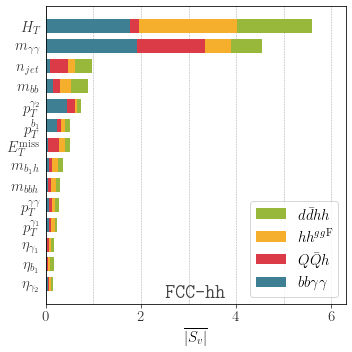

In [17]:
class_names = [r'$bb\gamma\gamma$', r'$Q\bar{Q}h$', r'$hh^{gg\rm F}$', r'$d \bar d hh$']
filename = '../results/models/FCC-hh-BDT/hh-BDT-4class-kd.pickle.dat'
shap_plot = '../plots/FCC-hh-shap-bbxaa-bbh-tth-hhsm-kd-only.pdf'

classifier, x_test, y_test, shap_values_4d, X_shap_4d = runBDT(df_train, filename, depth=10)
abs_shap(shap_values_4d, X_shap_4d, shap_plot, names=names, class_names=class_names, cmp=cmp_5)

In [18]:
kd_p = df_kd_test.sample(n=round(weight_kd), replace=True, random_state=seed).reset_index(drop=True)
hhsm_p = df_hhsm_test.sample(n=round(weight_hhsm), replace=True, random_state=seed).reset_index(drop=True)
bbh_tth_p = df_bbh_tth_test.sample(n=round(weight_bbh_tth), replace=True, random_state=seed).reset_index(drop=True)
bbxaa_p = df_bbxaa_test.sample(n=round(weight_bbxaa), replace=True, random_state=seed).reset_index(drop=True)

print('Accuracy Score for kd: {:4.2f}% '.format(100*metrics.accuracy_score(kd_p['class'].values, classifier.predict(kd_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for hhsm: {:4.2f}% '.format(100*metrics.accuracy_score(hhsm_p['class'].values, classifier.predict(hhsm_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for bbh+tth: {:4.2f}% '.format(100*metrics.accuracy_score(bbh_tth_p['class'].values, classifier.predict(bbh_tth_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for bbxaa: {:4.2f}% '.format(100*metrics.accuracy_score(bbxaa_p['class'].values, classifier.predict(bbxaa_p.drop(columns=['class', 'weight']).values))))

Accuracy Score for kd: 61.47% 
Accuracy Score for hhsm: 14.22% 
Accuracy Score for bbh+tth: 82.03% 
Accuracy Score for bbxaa: 93.32% 


In [19]:
df_array = [df_bbxaa_test, df_bbh_tth_test, df_hhsm, df_kd_test]
weight_array = [weight_bbxaa, weight_bbh_tth, weight_hhsm, weight_kd]
keys = ['kd', 'hhsm', 'tth+bbh', 'bbxaa']
filename = '../results/confusion/FCC-hh-BDT/hh-BDT-4class-kd-only.confusion.json'

df = build_confusion(df_array, weight_array, classifier, filename, keys)
df

,kd,hhsm,tth+bbh,bbxaa,Z
kd,27149,12502,51780,54753,71.007450
hhsm,2079,17454,6913,6081,96.777181
tth+bbh,13893,22827,1246683,1563536,738.868168
bbxaa,1215,584,214014,22692190,4741.140173
total,44336,53367,1519390,24316560,0.000000


_________________________________
## The kappa_u & kappa_d

In [20]:
df_ku['class'] = 4
df_ku_test['class'] = 4
df_kd['class'] = 3
df_kd_test['class'] = 3
df_hhsm['class'] = 2
df_hhsm_test['class'] = 2

channels = [df_ku, df_kd, df_hhsm, df_bbh_tth, df_bbxaa]
df_train = pd.concat(channels, ignore_index=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)

Accuracy Score: 79.97% 


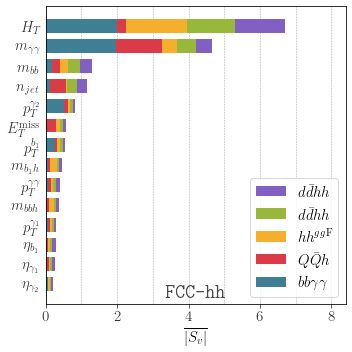

In [21]:
class_names = [r'$bb\gamma\gamma$', r'$Q\bar{Q}h$', r'$hh^{gg\rm F}$', r'$d \bar d hh$', r'$d \bar d hh$']
filename = '../results/models/FCC-hh-BDT/hh-BDT-5class-ku-kd.pickle.dat'
shap_plot = '../plots/FCC-hh-shap-bbxaa-bbh-tth-hhsm-ku-kd.pdf'

classifier, x_test, y_test, shap_values_5ud, X_shap_5ud = runBDT(df_train, filename, depth=10)
abs_shap(shap_values_5ud, X_shap_5ud, shap_plot, names=names, class_names=class_names, cmp=cmp_5)

In [22]:
ku_p = df_ku_test.sample(n=round(weight_ku), replace=True, random_state=seed).reset_index(drop=True)
kd_p = df_kd_test.sample(n=round(weight_kd), replace=True, random_state=seed).reset_index(drop=True)
hhsm_p = df_hhsm_test.sample(n=round(weight_hhsm), replace=True, random_state=seed).reset_index(drop=True)
bbh_tth_p = df_bbh_tth_test.sample(n=round(weight_bbh_tth), replace=True, random_state=seed).reset_index(drop=True)
bbxaa_p = df_bbxaa_test.sample(n=round(weight_bbxaa), replace=True, random_state=seed).reset_index(drop=True)

print('Accuracy Score for ku: {:4.2f}% '.format(100*metrics.accuracy_score(ku_p['class'].values, classifier.predict(ku_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for kd: {:4.2f}% '.format(100*metrics.accuracy_score(kd_p['class'].values, classifier.predict(kd_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for hhsm: {:4.2f}% '.format(100*metrics.accuracy_score(hhsm_p['class'].values, classifier.predict(hhsm_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for bbh+tth: {:4.2f}% '.format(100*metrics.accuracy_score(bbh_tth_p['class'].values, classifier.predict(bbh_tth_p.drop(columns=['class', 'weight']).values))))
print('Accuracy Score for bbxaa: {:4.2f}% '.format(100*metrics.accuracy_score(bbxaa_p['class'].values, classifier.predict(bbxaa_p.drop(columns=['class', 'weight']).values))))

Accuracy Score for ku: 34.07% 
Accuracy Score for kd: 34.24% 
Accuracy Score for hhsm: 12.92% 
Accuracy Score for bbh+tth: 81.81% 
Accuracy Score for bbxaa: 93.21% 


In [23]:
df_array = [df_bbxaa_test, df_bbh_tth_test, df_hhsm, df_kd_test, df_ku_test]
weight_array = [weight_bbxaa, weight_bbh_tth, weight_hhsm, weight_kd, weight_ku]
keys = ['ku', 'kd', 'hhsm', 'tth+bbh', 'bbxaa']
filename = '../results/confusion/FCC-hh-BDT/hh-BDT-5class-ku-kd.confusion.json'

df = build_confusion(df_array, weight_array, classifier, filename, keys)
df

,ku,kd,hhsm,tth+bbh,bbxaa,Z
ku,14202,13288,5873,25896,35841,46.053140
kd,13394,15080,9435,33866,34986,46.152478
hhsm,1475,1704,14369,5441,5685,84.855970
tth+bbh,11760,12978,23055,1243562,1573930,734.655154
bbxaa,999,1173,740,210561,22666217,4738.642818
total,41830,44223,53472,1519326,24316659,0.000000
